In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
from scipy import stats

import skimage as ski
from astropy.io import fits

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [4]:
def open_fits_image(image_path, image_data_header_location):
    print(f"Reading {image_path}")
    image_file = open(image_path, "rb")
    hdu_list = fits.open(image_file)
    hdu_list.info()
    image_data = hdu_list[image_data_header_location].data
    return image_data

def crop_image(image, coords, cropsize):
    offset_x, offset_y = coords
    width, height = cropsize
    # Crop image
    cropped_image = image[offset_y:offset_y + height, offset_x:offset_x + width]
    return cropped_image

In [5]:
def reshape_split(image: np.ndarray, kernel_size: int):
    img_height, img_width = image.shape
    tile_height = tile_width = kernel_size # tile must be square

    tiled_array = image.reshape(img_height // tile_height,
                                tile_height,
                                img_width // tile_width,
                                tile_width)
    tiled_array = tiled_array.swapaxes(1, 2)
    return tiled_array

In [13]:
upscaled_img = ski.io.imread('output.png', as_gray=True)

In [18]:
upscaled_img.shape

(8192, 8192)

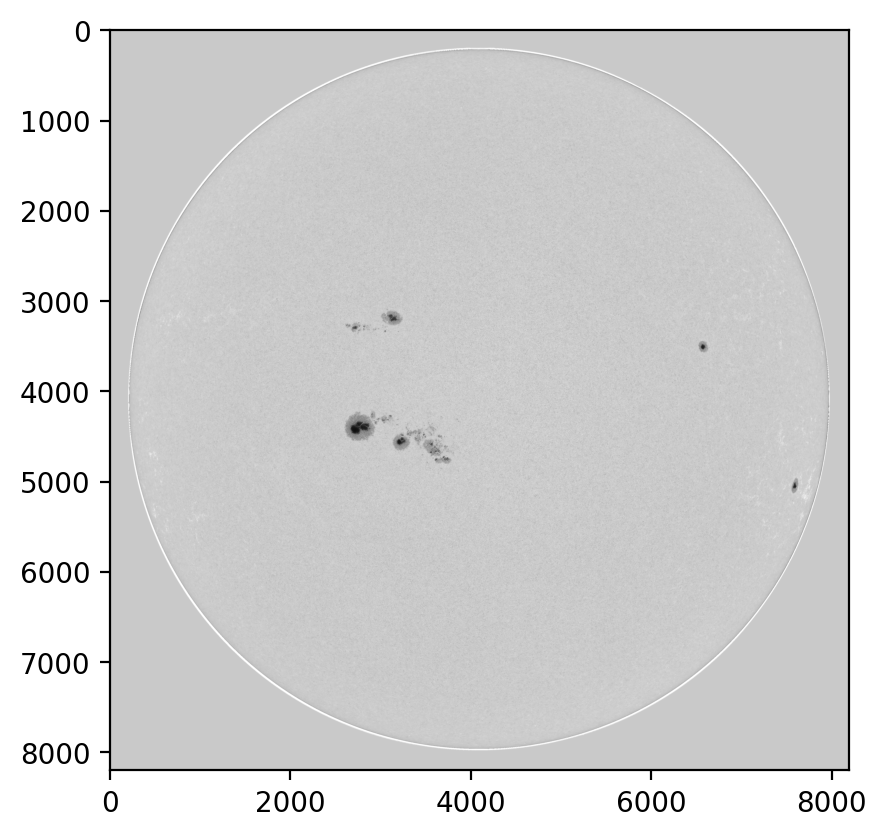

In [16]:
plt.imshow(upscaled_img, cmap='grey')

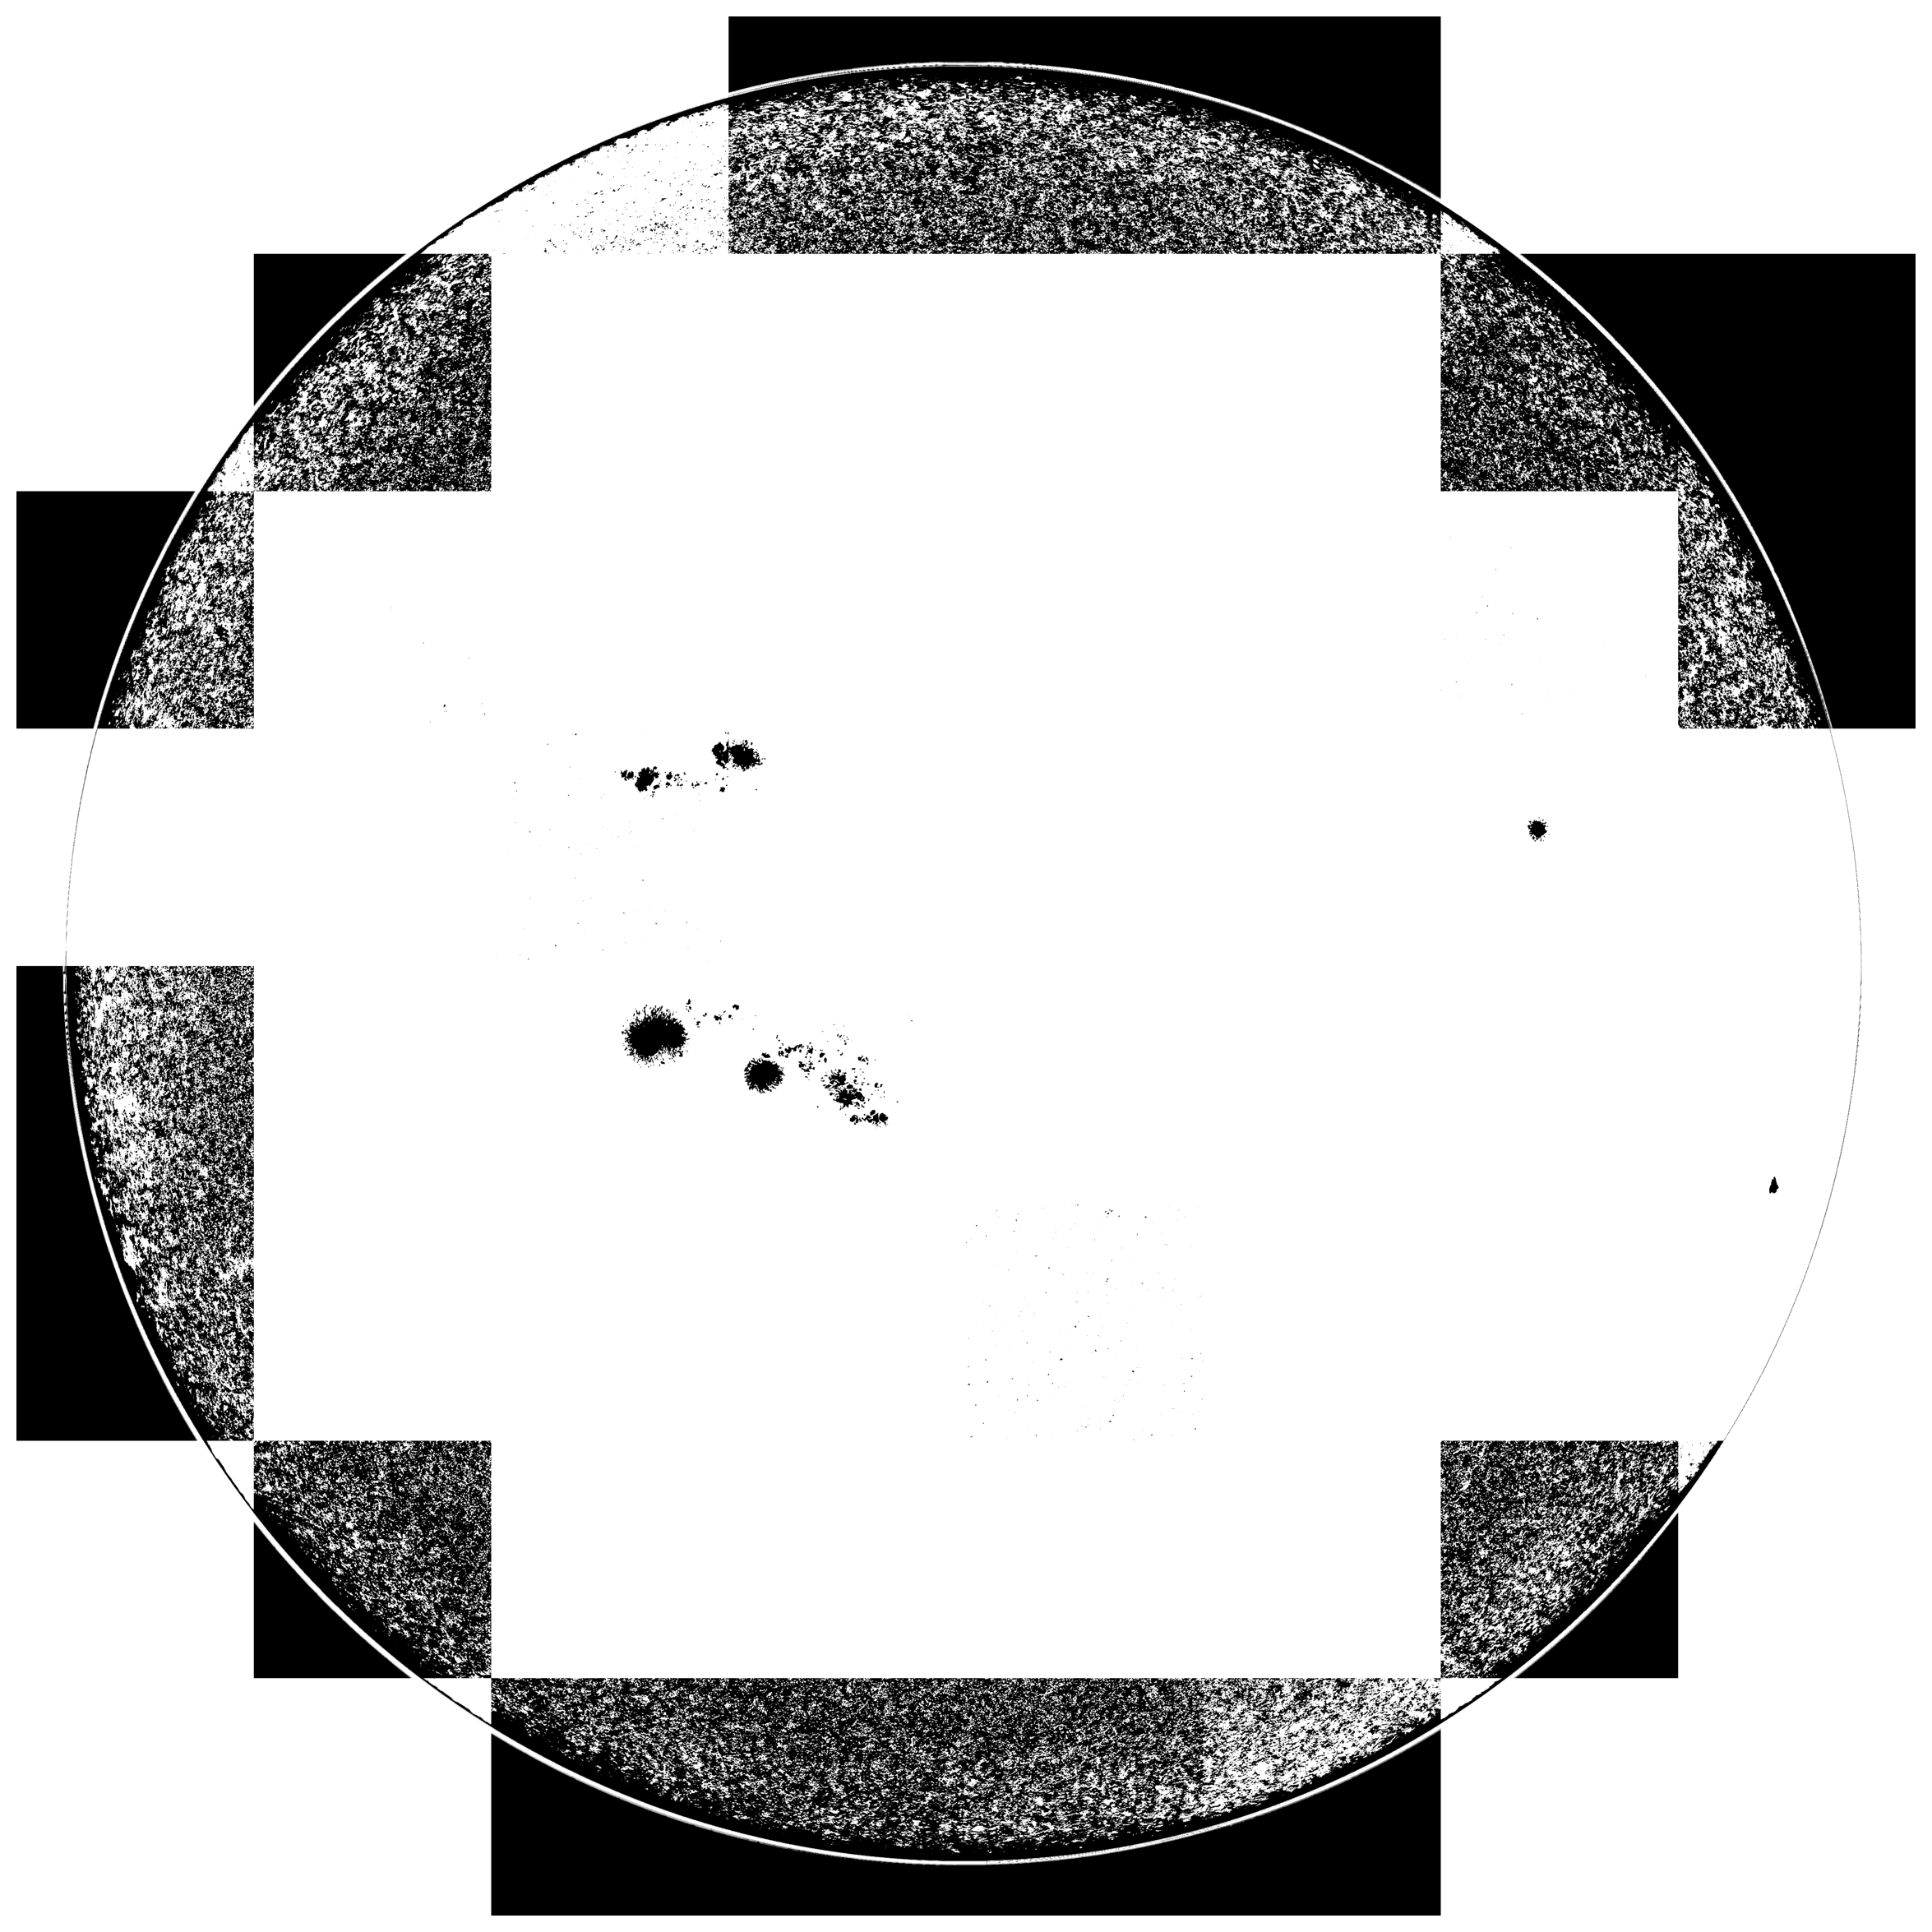

CPU times: user 7.02 s, sys: 835 ms, total: 7.85 s
Wall time: 7.86 s


In [24]:
%%time

# # read fits image
# img_name = '/home/jswen/dev/solar-yolo/data/fits_images/20150508/hmi.in_45s.20150508_000000_TAI.2.continuum.fits'
# # img_name = 'output.jpg'
# base_image = open_fits_image(img_name, 0)
base_image = upscaled_img
# split image into tiles
tile_size = 1024
base_size = base_image.shape[0]
divs = base_size//tile_size
num_tiles = int((divs)**2)
tiles = reshape_split(base_image, tile_size)

# flatten tile array along one dimension
tiles = tiles.reshape(num_tiles, tile_size, tile_size)

# apply threshold to each tile
thresholded = np.zeros_like(tiles, dtype='bool')
for i in range(0, tiles.shape[0]):
    img = tiles[i]
    if img.any():
        ints = img.flatten()
        mean = np.mean(ints)
        std = np.std(ints)
        # check if there's anything significantly darker than the background
        if np.any(ints < mean - 6*std):
            # threshold with Otsu's method
            thresh = ski.filters.threshold_otsu(img[img != 0])
            thresh = 0.9 * thresh
            otsu = img >= thresh
            thresholded[i] = otsu
            
            # # morphological segmentation using Chan-Vese
            # img = ski.img_as_float(img)
            # cv = ski.segmentation.chan_vese(img, mu=0.01, lambda1=1, lambda2=1, tol=1e-5,
            #                max_num_iter=1000, dt=1, init_level_set="checkerboard",
            #                extended_output=True)
            # thresholded[i] = cv[0]
        else:
            thresholded[i] = np.ones_like(img, dtype='bool')
    else:
        thresholded[i] = np.zeros_like(img, dtype='bool')

# reassemble thresholded tiles into grid
thresholded = thresholded.reshape(divs, divs, tile_size, tile_size)
# stitch them together
stitched = thresholded.swapaxes(1, 2).reshape(8192, 8192)

plt.figure(figsize=(15, 15))
plt.imshow(stitched, cmap='grey')
ax = plt.gca()
ax.set_axis_off()
plt.savefig('segmentation.png', dpi=300)
plt.show()

In [13]:
num_tiles

256

In [17]:
256*16

4096

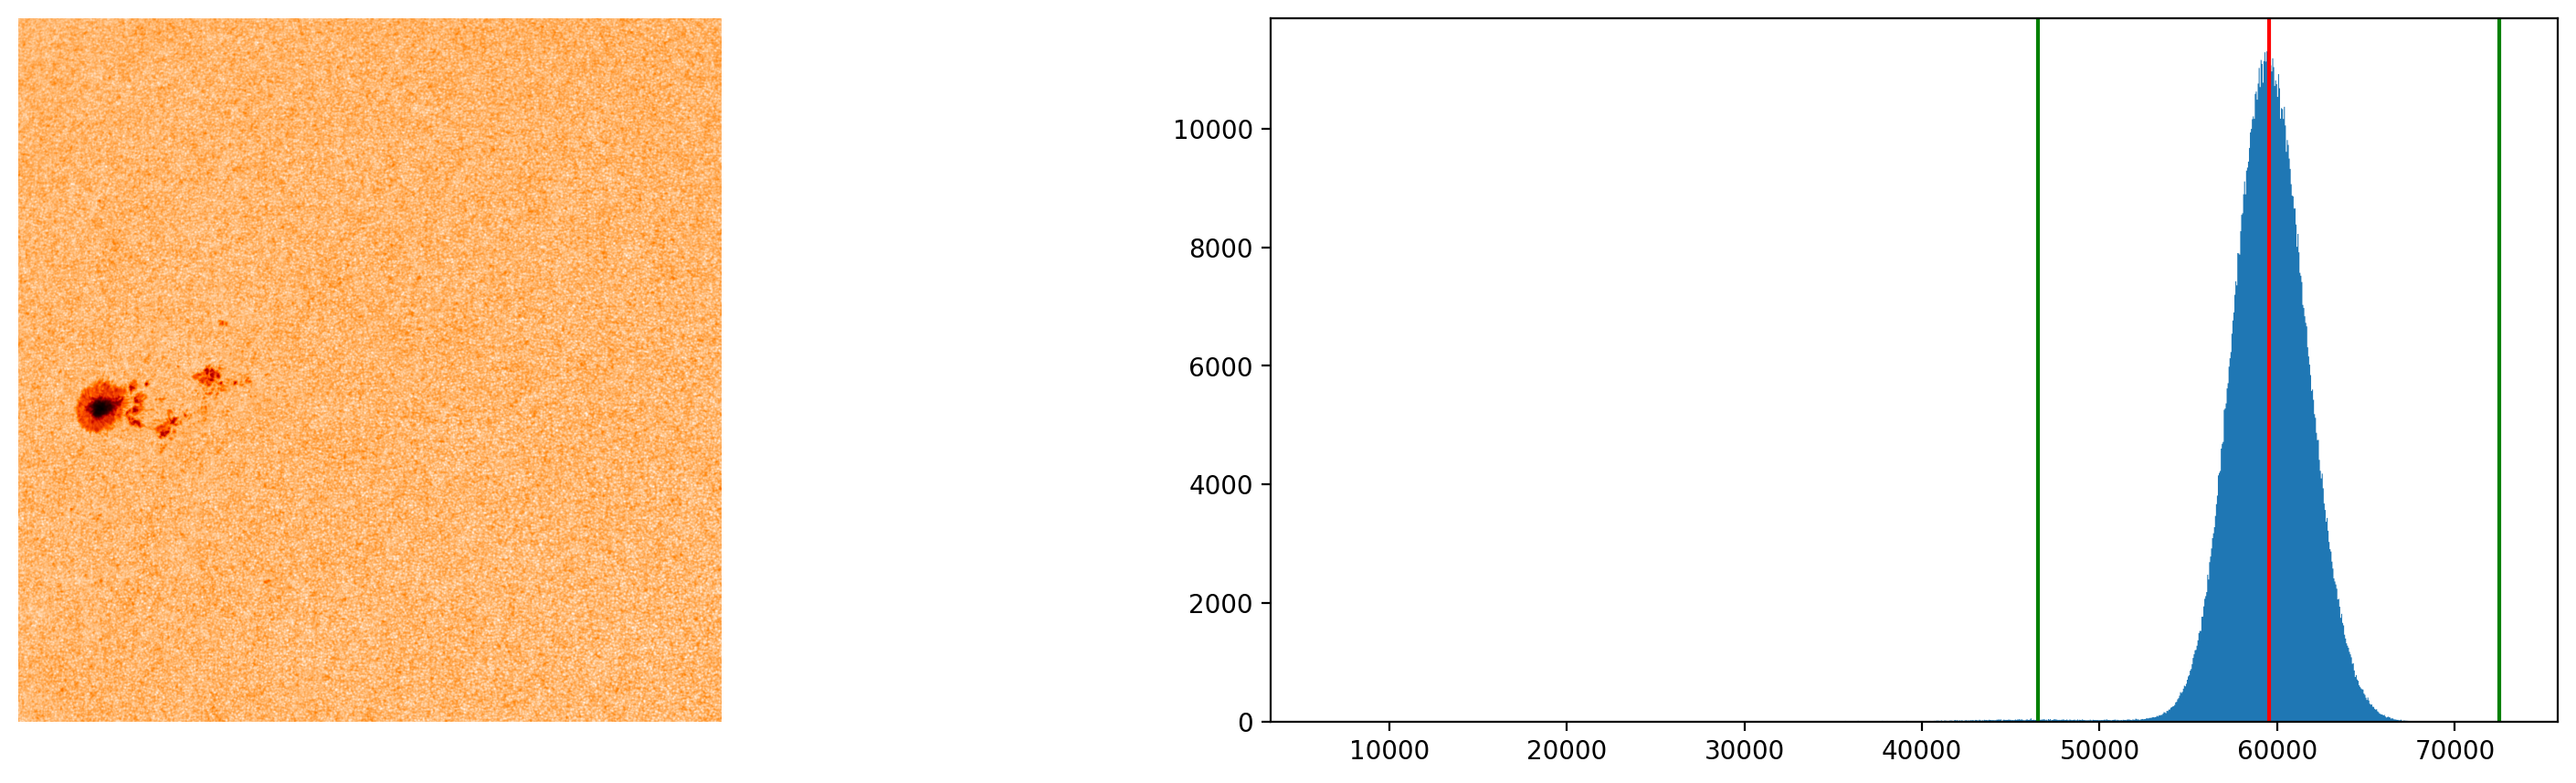

In [75]:
tile = tiles[8:10].swapaxes(0, 1).reshape(1024, 2048)
tile = tiles[5]
intensities = tile.flatten()
mean = np.mean(intensities)
std = np.std(intensities)
var = np.var(intensities)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(tile, cmap='gist_heat')
ax[0].set_axis_off()
ax[1].hist(intensities, bins='auto', histtype='stepfilled')
ax[1].axvline(mean, c='r')
ax[1].axvline(mean-5*std, c='g')
ax[1].axvline(mean+5*std, c='g')
plt.show()

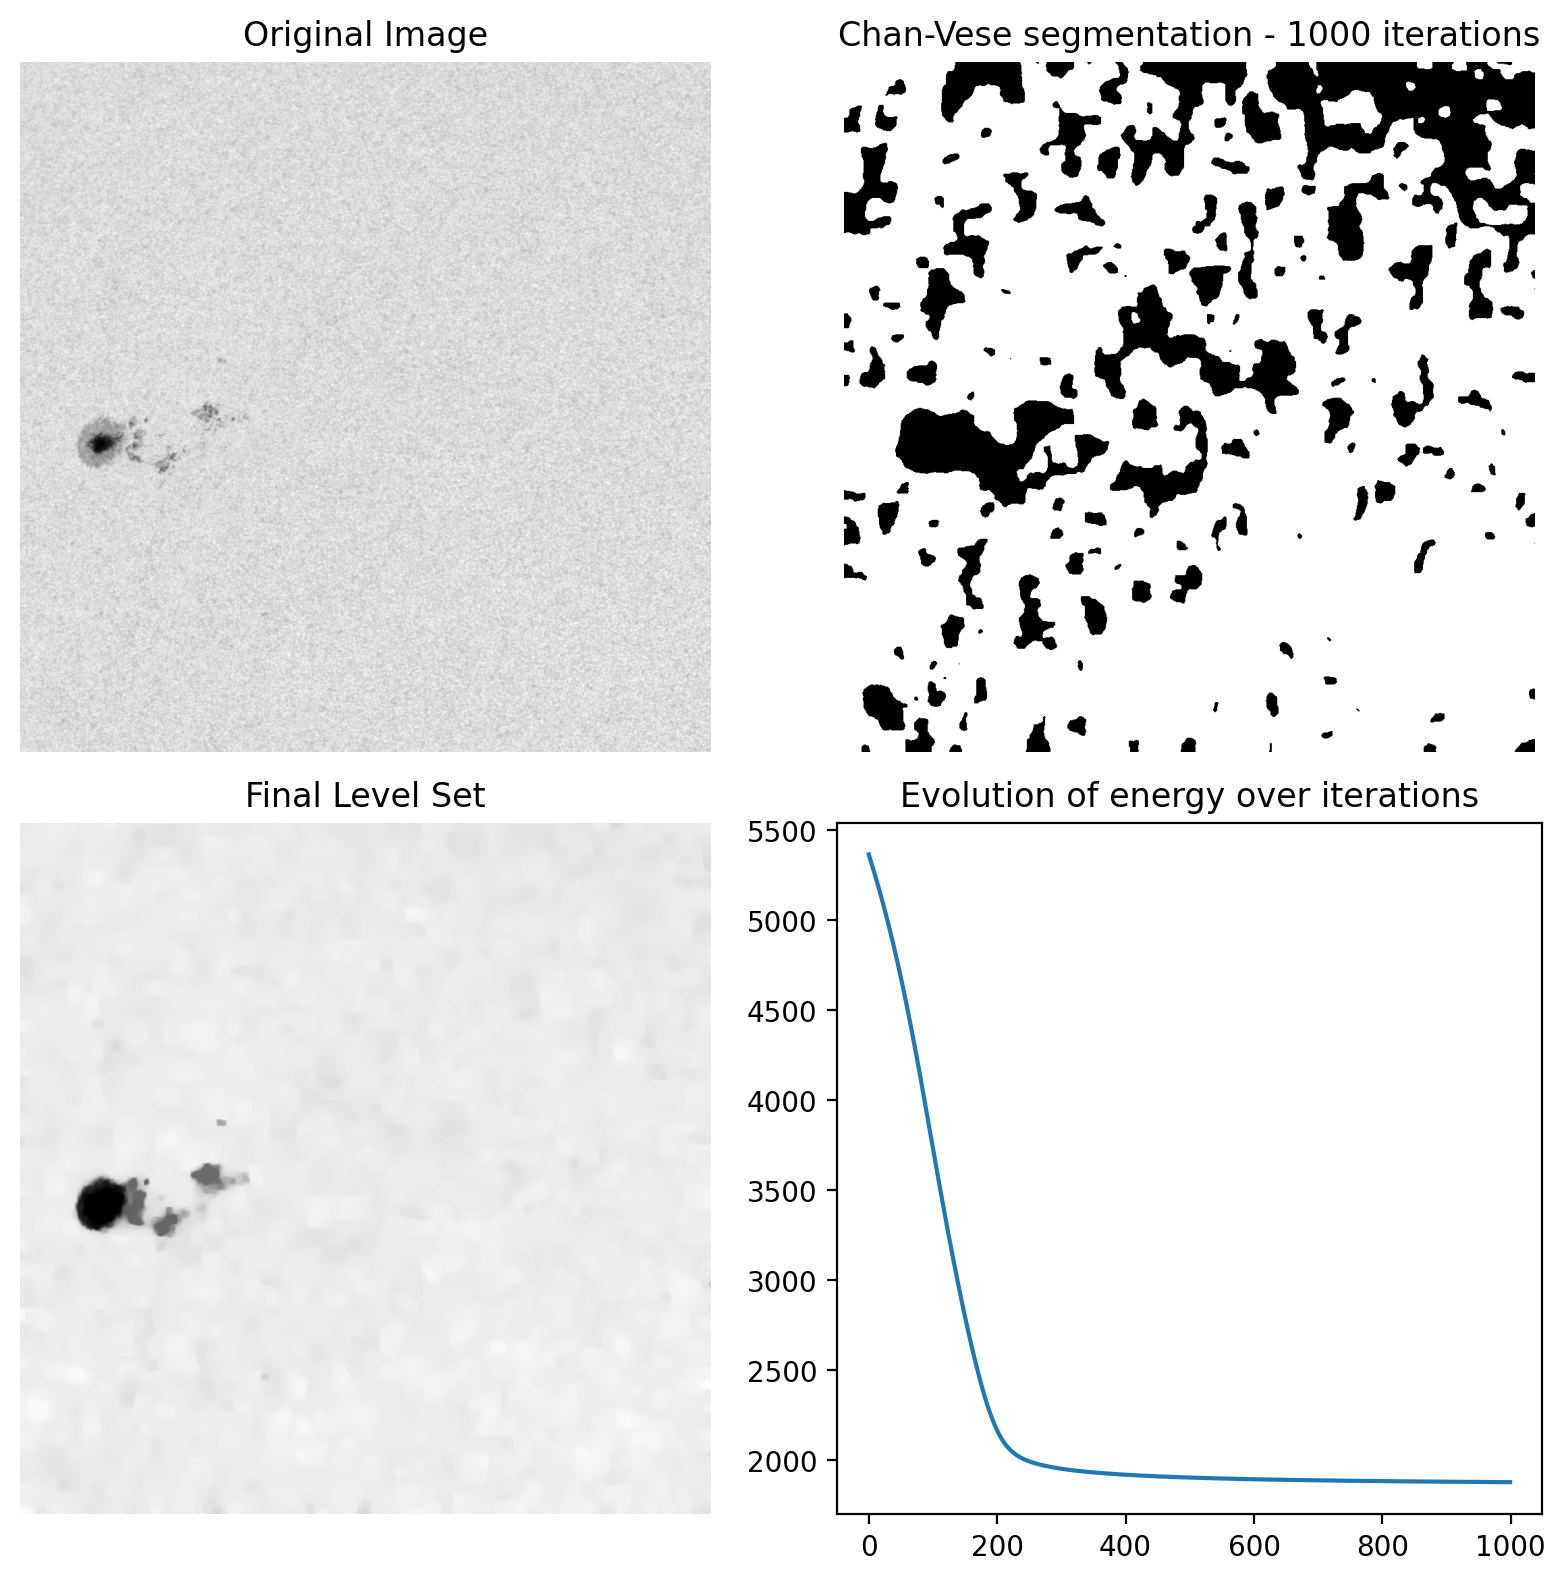

CPU times: user 2min 28s, sys: 662 ms, total: 2min 29s
Wall time: 2min 29s


In [77]:
%%time
image = ski.img_as_float(tile)
# Feel free to play around with the parameters to see how they impact the result
cv = ski.segmentation.chan_vese(image, mu=0.01, lambda1=1, lambda2=1, tol=1e-5,
               max_num_iter=1000, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [39]:
cv[0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [92]:
mean_arr = np.zeros(256)
stdev_arr = np.zeros(256)
for i in range(0, tiles.shape[0]):
    img = tiles[i]
    intensities = img.flatten()
    mean = np.mean(intensities)
    std = np.std(intensities)
    mean_arr[i] = mean
    stdev_arr[i] = std

mean_arr = mean_arr.reshape(16, 16)
stdev_arr = stdev_arr.reshape(16, 16)

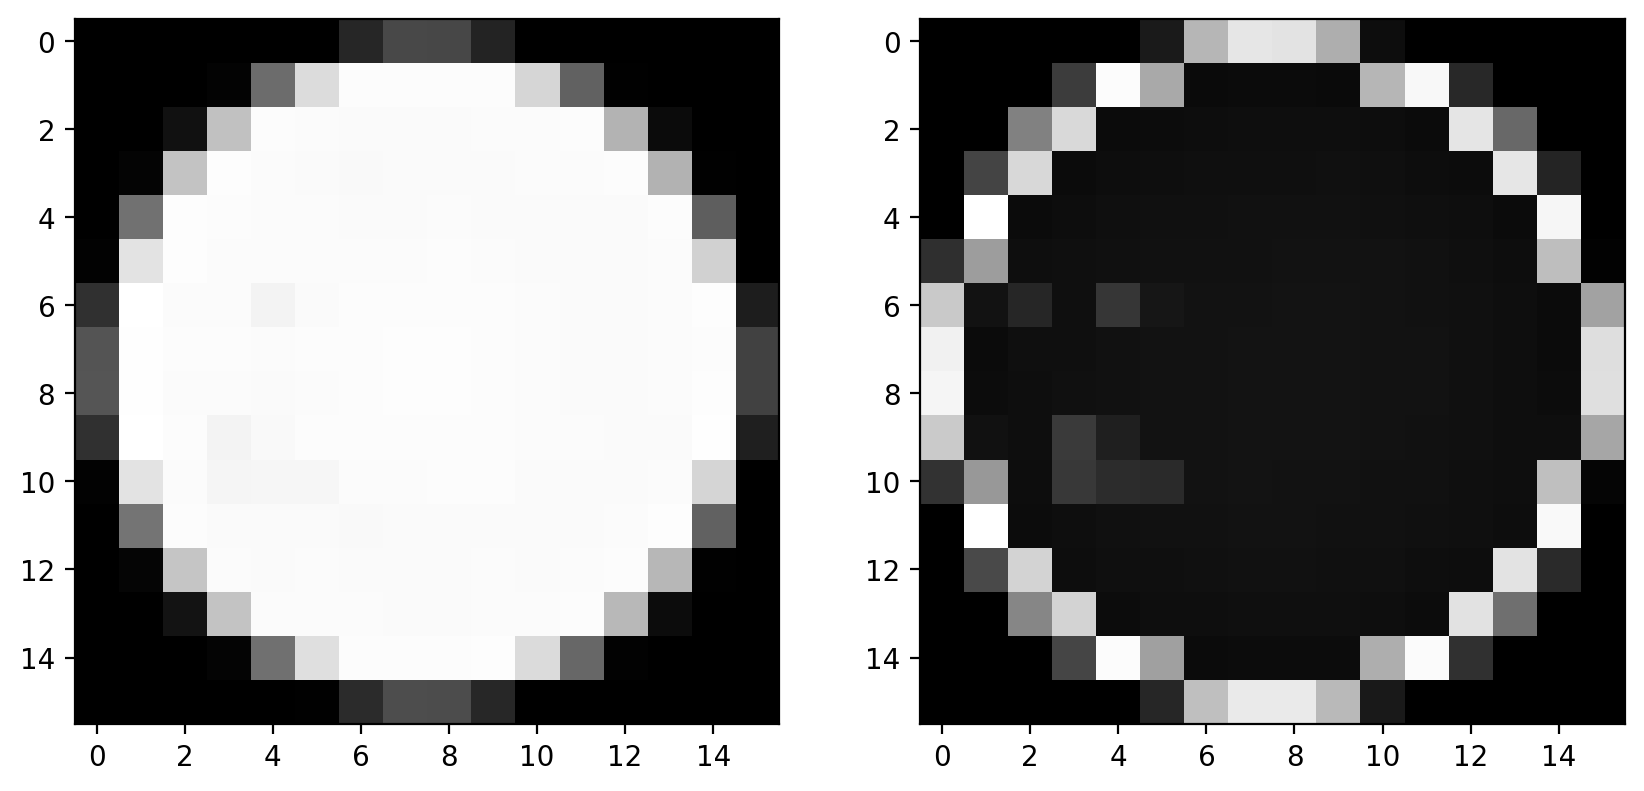

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mean_arr, cmap='grey')
ax[1].imshow(stdev_arr, cmap='grey')
plt.show()

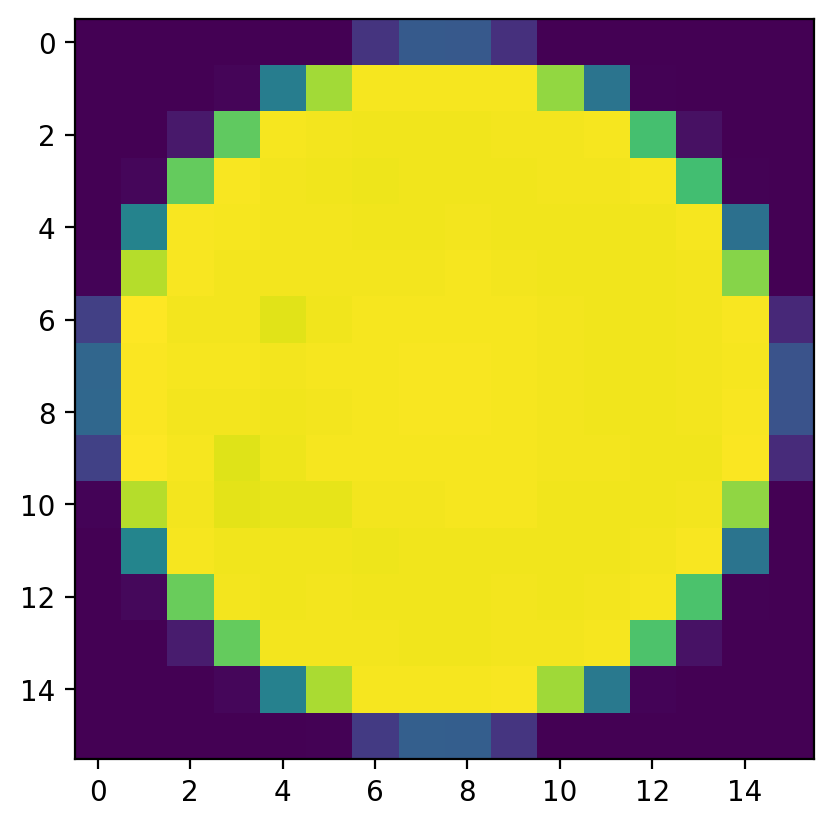

In [97]:
plt.imshow(mean_arr)

In [ ]:
crop = crop_image(base_image, (1024-256, 2560-256), (256, 256))
crop = crop.astype(np.uint32)
plt.imshow(crop)

In [ ]:
from skimage.segmentation import quickshift

In [ ]:
rgbcrop = gray2rgb(crop_as_ubyte)

In [ ]:
segments = quickshift(rgbcrop, sigma=2, convert2lab=True)
plt.imshow(segments)

In [ ]:
rescaled = rescale_intensity(crop)
crop_as_ubyte = img_as_ubyte(rescaled)
plt.imshow(crop_as_ubyte)

In [ ]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte


img = crop_as_ubyte

radius = 5
footprint = disk(radius)

local_otsu = rank.otsu(img, footprint)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title(f'Local Otsu (radius={radius})')
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu')
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title(f'Global Otsu (threshold = {threshold_global_otsu})')
ax[3].axis('off')

plt.show()

In [ ]:
elevation_map = sobel(crop)
plt.imshow(elevation_map)

In [ ]:
hist, hist_centers = histogram(crop)
plt.plot(hist_centers, hist)

In [ ]:
markers = np.zeros_like(crop)
markers[crop > 65000] = 1
markers[crop < 40000] = 2
plt.imshow(markers)

In [ ]:
segmentation = watershed(elevation_map, markers=markers)
plt.imshow(segmentation)

In [ ]:
elevation_map.shape

In [ ]:
X = np.arange(0, 256, 1)

In [ ]:
X = np.arange(0, 256, 1)
Y = np.arange(0, 256, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)

In [ ]:
np.max(elevation_map), np.min(elevation_map)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

# Make data.
X = np.arange(0, 256, 1)
Y = np.arange(0, 256, 1)
X, Y = np.meshgrid(X, Y)
Z = elevation_map

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(0, 1e-5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Set the projection type.
ax.set_proj_type('ortho')

# Set the viewing angle.
ax.view_init(elev=70, azim=45, roll=0)

plt.show()